# Computing energies using `smee`

This example will show how the energy of a water dimer (TIP4P-FB and TIP3P) in multiple conformations can be evaluated using `smee` framework. 

We start by creating the objects that will store our parameterized water dimer. First we will create a single water molecule, and parameterize it using OpenFF Interchange:

In [1]:
import openff.toolkit
import openff.units
import torch

water = openff.toolkit.Molecule.from_smiles("O")
water.generate_conformers(n_conformers=1)

import openff.interchange

tip4p_interchange = openff.interchange.Interchange.from_smirnoff(
    openff.toolkit.ForceField("tip4p_fb.offxml"), water.to_topology()
)

The interchange must then be mapped into collections of tensors:

In [2]:
import smee.converters

tip4p_tensor_ff, [tip4p_topology] = smee.converters.convert_interchange(
    tip4p_interchange
)

**Note:** The `convert_interchange` function can take either a single interchange object, or a list of multiple.

These tensors are returned as:

* a `smee.ff.TensorForceField` oject: this stores the original values of the force field parameters in tensor form.
* a list of ``smee.ff.TensorTopology`` objects: each 'topology' will store basic information about each input molecule, in addition to matrices defining which parameters were assigned to which elements (e.g. bonds, angles, torsions) and any virtual sites that were added.

To define fuller systems (e.g. dimers, condensed phase systems etc), we need to wrap the topologies in a system object:

In [3]:
tip4p_dimer = smee.TensorSystem([tip4p_topology], n_copies=[2], is_periodic=False)

This mirrors how GROMACS topology files are defined, whereby individual species are parameterised and then a count of how many of each should be present is specified. This avoids the need to store multiple copies of the same parameters for each copy of a given molecule.

We can then define the coordinates of our dimers:

In [4]:
water_conformer = torch.tensor(water.conformers[0].m_as(openff.units.unit.angstrom))
tip4p_conformer = smee.add_v_site_coords(
    tip4p_topology.v_sites, water_conformer, tip4p_tensor_ff
)

tip4p_conformers = torch.stack(
    [
        torch.vstack([tip4p_conformer, tip4p_conformer + torch.tensor(1.5 + i * 0.05)])
        for i in range(40)
    ]
)
tip4p_conformers.shape

torch.Size([40, 8, 3])

For simplicity, we have created 40 dimer conformers, with a separation ranging from 1.5-3.5 Å by crudely shifting our initial conformer along the x-axis. 

**Note:** Conformers should either be tensor with a shape of `(n_particles, 3)` or `(n_conformers, n_particles, 3)`, and units of Å._

From the shape we can clearly see there are 40 conformers, each with coordinates for 8 particles (i.e. 3 for each water molecule + 1 virtual site on each).

The energy each dimer can then be directly evaluated and plotted

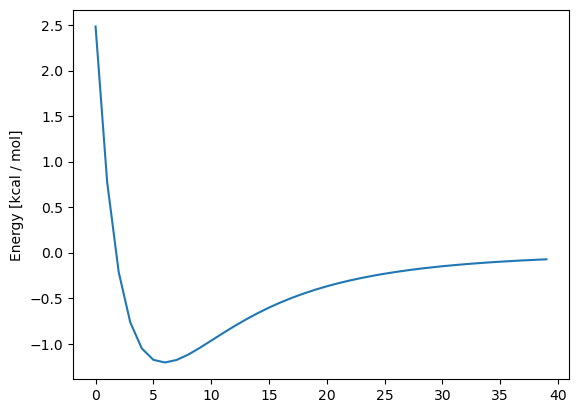

In [5]:
tip4p_energies = smee.compute_energy(tip4p_dimer, tip4p_tensor_ff, tip4p_conformers)

from matplotlib import pyplot

pyplot.plot(tip4p_energies, label="tip4p")
pyplot.ylabel("Energy [kcal / mol]");

The above can easily be repeated using the TIP3P water model, allowing us to compare the dimer energy curves.

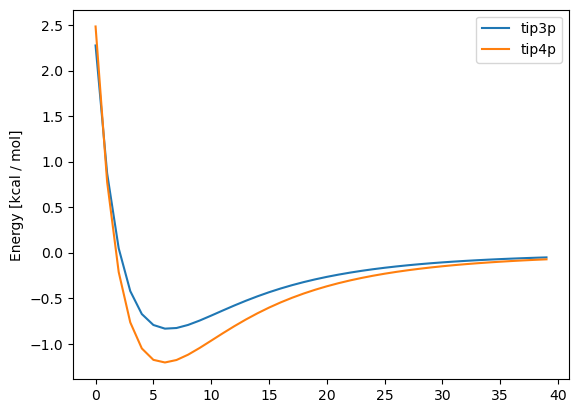

In [6]:
tip3p_interchange = openff.interchange.Interchange.from_smirnoff(
    openff.toolkit.ForceField("tip3p.offxml"), water.to_topology()
)

tip3p_tensor_ff, [tip3p_tensor_topology] = smee.converters.convert_interchange(
    tip3p_interchange
)
tip3p_dimer = smee.TensorSystem(
    [tip3p_tensor_topology], n_copies=[2], is_periodic=False
)

tip3p_conformers = torch.stack(
    [
        torch.vstack([water_conformer, water_conformer + torch.tensor(1.5 + i * 0.05)])
        for i in range(40)
    ]
)

tip3p_energies = smee.compute_energy(tip3p_dimer, tip3p_tensor_ff, tip3p_conformers)

pyplot.plot(tip3p_energies, label="tip3p")
pyplot.plot(tip4p_energies, label="tip4p")

pyplot.ylabel("Energy [kcal / mol]")
pyplot.legend();

A further advantage of storing our applied force field parameters in smee form is the ability to compute only the energy due to a particular handler (e.g. only LJ energies). 

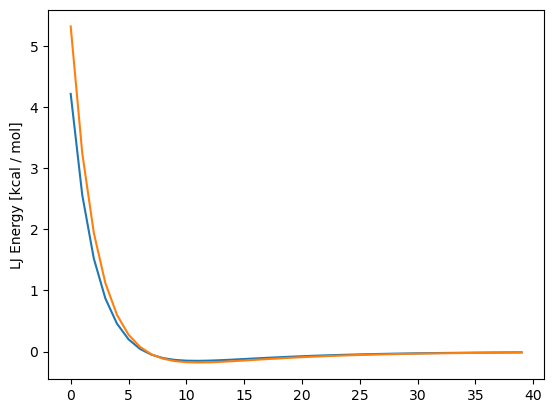

In [7]:
tip3p_lj_energies = smee.compute_energy_potential(
    tip3p_dimer, tip3p_tensor_ff.potentials_by_type["vdW"], tip3p_conformers
)
tip4p_lj_energies = smee.compute_energy_potential(
    tip4p_dimer, tip4p_tensor_ff.potentials_by_type["vdW"], tip4p_conformers
)

pyplot.plot(tip3p_lj_energies, label="tip3p")
pyplot.plot(tip4p_lj_energies, label="tip4p")

pyplot.ylabel("LJ Energy [kcal / mol]");